# Responses for RXTE PCA event-mode

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# try:
#     import seaborn as sns
# except ImportError:
#     print("No seaborn installed. Oh well.")
    
import numpy as np 
# import pandas as pd
import astropy.io.fits as fits
from astropy.table import Table
# import sherpa.astro.ui as ui
import astropy.modeling.models as models
from astropy.modeling.fitting import _fitter_to_model_params
from scipy.special import gammaln as scipy_gammaln
import os.path

# from clarsach.respond import RMF, ARF

Let's load some PCA simulations of a simple power law. The input values for that spectrum are:
* `norm = 1`
* `ph_index = 2`

In [2]:
datadir = "../data"
if not os.path.exists(datadir):
    print("Data directory does not exist.")

We'll read in the fake spectrum using astropy tables.

In [44]:
data = Table.read(datadir+"/RXTE_PCA_EVT_PCU2.fak")

Let's look at the general spectrum info and fits metadata. Note that for a fake spectrum like this, there is less metadata than there'd be for a 'real' reduced spectrum.

In [45]:
# print(data)
print(data.info)
print(data.meta)

<Table length=64>
  name   dtype
-------- -----
 CHANNEL int32
  COUNTS int32
 QUALITY int16
GROUPING int16

OrderedDict([('EXTNAME', 'SPECTRUM'), ('HDUCLASS', 'OGIP'), ('HDUCLAS1', 'SPECTRUM'), ('HDUVERS1', '1.1.0'), ('TELESCOP', 'XTE'), ('INSTRUME', 'PCA'), ('CHANTYPE', 'PHA'), ('DATE', '2017-05-11T08:46:08'), ('HISTORY', ['Fake data file created by XSPEC version: 12.9.0n "fakeit" command']), ('FKSRC001', 'powerlaw'), ('FKRSP001', 'PCU2.rsp'), ('RESPFILE', 'PCU2.rsp'), ('ANCRFILE', ''), ('CORRFILE', ''), ('CORRSCAL', -1.0), ('BACKFILE', ''), ('EXPOSURE', 100000.0), ('TLMIN1', 0), ('TLMAX1', 63), ('DETCHANS', 64), ('POISSERR', True), ('AREASCAL', 1.0), ('BACKSCAL', 1.0)])


We also want to read in the response file. For RXTE, we used the HEASOFT command PCARSP to make the response file, which combines the rmf (redistribution matrix function) and arf (anciliary response file; the effective area curve of the instrument) into one fits file with two HDUs. For more on these files with RXTE, see here: https://heasarc.nasa.gov/docs/xte/recipes/pca_response.html

The first HDU has the response information for each channel of the detector (for RXTE, this is 300) and the response matrix saved in a weird form as a sparse matrix. The response is the product of the RMF and ARF.

The channels are then grouped for each different 'data mode', which is how you get e.g. 256 channels for a Standard-2 spectrum, or 64 energy channels for event mode, or 8 channels for binned mode. The energy boundaries for those binned channels are in the second fits HDU.

In [5]:
rsp = Table.read(datadir+"/"+data.meta['RESPFILE'], hdu=1)
ebounds = Table.read(datadir+"/"+data.meta['RESPFILE'], hdu=2)

Let's look at the info and metadata for the response table:

In [6]:
print(rsp.info)
# print(rsp.meta)

<Table length=300>
  name    dtype  shape unit
-------- ------- ----- ----
ENERG_LO float32        keV
ENERG_HI float32        keV
   N_GRP   int16           
  F_CHAN   int16  (3,)     
  N_CHAN   int16  (3,)     
  MATRIX  object           



(that's a lot of metadata!)

And let's also look at it for the energy bounds of the data mode's channels.

In [7]:
print(ebounds.info)
# print(ebounds.meta)

<Table length=64>
  name   dtype  unit
------- ------- ----
CHANNEL   int32     
  E_MIN float32  keV
  E_MAX float32  keV



Just to see what we're working with, let's compute the midpoint of the data mode energy bins, and plot it with the raw spectrum counts.

In [8]:
bin_mid = ebounds['E_MIN'] + (ebounds['E_MAX'] - ebounds['E_MIN']) / 2.

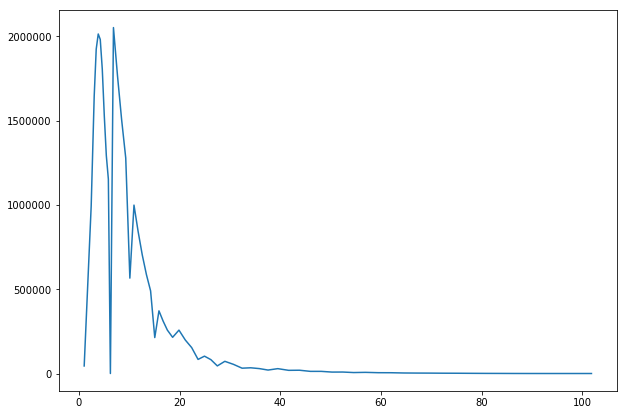

In [9]:
plt.figure(figsize=(10,7))
plt.plot(bin_mid, data['COUNTS'])

Now we can make a model spectrum we can play around with! `clarsach` has an implementation of a Powerlaw model that matches the `XSPEC` one that created the data:

In [10]:
from clarsach.models.powerlaw import Powerlaw
pl = Powerlaw(norm=1.0, phoindex=2.0)

Now we can produce a model with the same resolution as the PCA data mode:

In [100]:
m = pl.calculate(ener_lo=rsp["ENERG_LO"], ener_hi=rsp["ENERG_HI"])

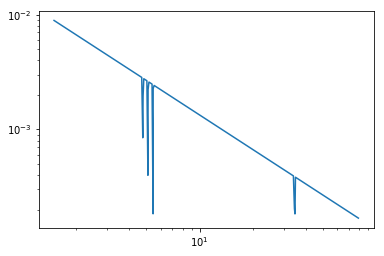

In [103]:
plt.figure()
plt.loglog(rsp["ENERG_LO"], m)

The energy resolution isn't impressive in this data mode 😔

 ## Making Our Own RMF Class

We're now going to write our own implementations of the rmf, and then test it on the power-law model above. For an RXTE rsp matrix made in PCARSP like what we've loaded in this notebook, the matrix can be treated like it's just an RMF, even though it's actually the combined RMF and ARF. To see an example that applies a separate ARF before an RMF, look at TestChandraHETG.ipynb.

In [104]:
## This is copy/pasted from clarsach/clarsach/respond.py
class RMF(object):
    
    def __init__(self, filename):
        
        self._load_rmf(filename)
        pass
    
    def _load_rmf(self, filename):
        """
        Load an RMF from a FITS file.
        
        Parameters
        ----------
        filename : str
            The file name with the RMF file
            
        Attributes
        ----------
        n_grp : numpy.ndarray
            the Array with the number of channels in each 
            channel set
        
        f_chan : numpy.ndarray
            The starting channel for each channel group;
            If an element i in n_grp > 1, then the resulting 
            row entry in f_chan will be a list of length n_grp[i];
            otherwise it will be a single number
            
        n_chan : numpy.ndarray
            The number of channels in each channel group. The same 
            logic as for f_chan applies
            
        matrix : numpy.ndarray
            The redistribution matrix as a flattened 1D vector
            
        energ_lo : numpy.ndarray
            The lower edges of the energy bins
        
        energ_hi : numpy.ndarray
            The upper edges of the energy bins
            
        detchans : int
            The number of channels in the detector
        
        """
        # open the FITS file and extract the MATRIX extension
        # which contains the redistribution matrix and 
        # anxillary information
        hdulist = fits.open(filename)

        # get all the extension names
        extnames = np.array([h.name for h in hdulist])

        # figure out the right extension to use
        if "MATRIX" in extnames:
            h = hdulist["MATRIX"]

        elif "SPECRESP MATRIX" in extnames:
            h = hdulist["SPECRESP MATRIX"]

        data = h.data
        hdr = h.header
        hdulist.close()
        
        # extract + store the attributes described in the docstring 
        n_grp = np.array(data.field("N_GRP"))
        f_chan = np.array(data.field('F_CHAN'))
        n_chan = np.array(data.field("N_CHAN"))
        matrix = np.array(data.field("MATRIX"))

        self.energ_lo = np.array(data.field("ENERG_LO"))
        self.energ_hi = np.array(data.field("ENERG_HI"))
        self.detchans = hdr["DETCHANS"]
        self.offset = self.__get_tlmin(h)

        # flatten the variable-length arrays
        self.n_grp, self.f_chan, self.n_chan, self.matrix = \
                self.__flatten_arrays(n_grp, f_chan, n_chan, matrix)
        
        return
    
    def __get_tlmin(self, h):
        """
        Get the tlmin keyword for `F_CHAN`.
        
        Parameters
        ----------
        h : an astropy.io.fits.hdu.table.BinTableHDU object
            The extension containing the `F_CHAN` column
            
        Returns
        -------
        tlmin : int
            The tlmin keyword
        """
        # get the header
        hdr = h.header
        # get the keys of all 
        keys = np.array(list(hdr.keys()))
        
        # find the place where the tlmin keyword is defined
        t = np.array(["TLMIN" in k for k in keys])
        
        # get the index of the TLMIN keyword
        tlmin_idx = np.hstack(np.where(t))[0]
        
        # get the corresponding value
        tlmin = np.int(list(hdr.items())[tlmin_idx][1])
        
        return tlmin
        
    def __flatten_arrays(self, n_grp, f_chan, n_chan, matrix):
        
        # find all non-zero groups
        nz_idx = (n_grp > 0)
        
        # stack all non-zero rows in the matrix
        matrix_flat = np.hstack(matrix[nz_idx])
        
        # stack all nonzero rows in n_chan and f_chan
        n_chan_flat = np.hstack(n_chan[nz_idx])
        f_chan_flat = np.hstack(f_chan[nz_idx])
        
        return n_grp, f_chan_flat, n_chan_flat, matrix_flat
            
    def apply_rmf(self, spec):
        """
        Fold the spectrum through the redistribution matrix.

        The redistribution matrix is saved as a flattened 1-dimensional 
        vector to save space. In reality, for each entry in the flux 
        vector, there exists one or more sets of channels that this 
        flux is redistributed into. The additional arrays `n_grp`, 
        `f_chan` and `n_chan` store this information:
            * `n_group` stores the number of channel groups for each 
              energy bin
            * `f_chan` stores the *first channel* that each channel 
              for each channel set 
            * `n_chan` stores the number of channels in each channel 
              set 
              
        As a result, for a given energy bin i, we need to look up the 
        number of channel sets in `n_grp` for that energy bin. We 
        then need to loop over the number of channel sets. For each 
        channel set, we look up the first channel into which flux 
        will be distributed as well as the number of channels in the 
        group. We then need to also loop over the these channels and 
        actually use the corresponding elements in the redistribution 
        matrix to redistribute the photon flux into channels. 
        
        All of this is basically a big bookkeeping exercise in making 
        sure to get the indices right.
        
        Parameters
        ----------
        spec : numpy.ndarray
            The (model) spectrum to be folded

        Returns
        -------
        counts : numpy.ndarray
            The (model) spectrum after folding, in 
            counts/s/channel

        """    

        # an empty array for the output counts
        counts = np.zeros(self.detchans)

        # index for n_chan and f_chan incrementation
        k = 0

        # index for the response matrix incrementation
        resp_idx = 0

        # loop over all channels
        for i in range(self.detchans):
            # this is the current bin in the flux spectrum to
            # be folded
            source_bin_i = spec[i]

            # get the current number of groups 
            current_num_groups = self.n_grp[i]

            # loop over the current number of groups
            for j in range(current_num_groups):

                # get the right index for the start of the counts array 
                # to put the data into
                counts_idx = int(self.f_chan[k] - self.offset)
                # this is the current number of channels to use
                current_num_chans = int(self.n_chan[k])
                # iterate k for next round
                k += 1

                # add the flux to the subarray of the counts array that starts with 
                # counts_idx and runs over current_num_chans channels
                counts[counts_idx:counts_idx+current_num_chans] +=  np.sum(self.matrix[resp_idx:resp_idx+current_num_chans] * \
                                                                  np.float(source_bin_i))
                # iterate the response index for next round
                resp_idx += current_num_chans

        return counts

In [105]:
print()

In [120]:
def rmf_fold(spec, rmf):
    
    current_num_groups = 0
    current_num_chans = 0
    
    nchannels = spec.shape[0]
    
    resp_idx = 0
    first_chan_idx = 0
    num_chans_idx =0
    counts_idx = 0
    
    counts = np.zeros(nchannels)
    
    for i in range(nchannels):
        source_bin_i = spec[i]
        current_num_groups = rmf['N_GRP'][i]
        
        print("current_num_groups: " + str(current_num_groups))
        for j in range(current_num_groups):
            print("first_chan_idx: " + str(first_chan_idx))
            print('rmf["F_CHAN"][first_chan_idx]: ' + str(rmf["F_CHAN"][first_chan_idx]))
            
            counts_idx = int(rmf['F_CHAN'][first_chan_idx, j])  # assuming 0 offset, since TLMIN returns key error
            print("counts_idx: " + str(counts_idx))
            current_num_chans = rmf['N_CHAN'][num_chans_idx, j]
            print("current_num_chans: " + str(current_num_chans))
            
            first_chan_idx += 1
            num_chans_idx +=1 
            
            while current_num_chans:
                print("counts_idx: " + str(counts_idx))
                print("resp_idx: " + str(resp_idx))

                print("rmf['MATRIX'][resp_idx]: " + str(rmf['MATRIX'][resp_idx]))
                print("source_bin_i: " + str(source_bin_i))
                counts[counts_idx] += np.sum(rmf['MATRIX'][resp_idx]) * source_bin_i
                counts_idx += 1
                resp_idx += 1
                current_num_chans -= 1
            
            #current_num_groups -= 1
            
    return counts

In [123]:
len(rsp["MATRIX"])

300

In [121]:
m_rmf = rmf_fold(m, rsp)

current_num_groups: 1
first_chan_idx: 0
rmf["F_CHAN"][first_chan_idx]: [0 0 0]
counts_idx: 0
current_num_chans: 1
counts_idx: 0
resp_idx: 0
rmf['MATRIX'][resp_idx]: [ 0.0125095]
source_bin_i: 0.00889635
current_num_groups: 1
first_chan_idx: 1
rmf["F_CHAN"][first_chan_idx]: [0 0 0]
counts_idx: 0
current_num_chans: 1
counts_idx: 0
resp_idx: 1
rmf['MATRIX'][resp_idx]: [ 0.01964481]
source_bin_i: 0.00877762
current_num_groups: 1
first_chan_idx: 2
rmf["F_CHAN"][first_chan_idx]: [0 0 0]
counts_idx: 0
current_num_chans: 1
counts_idx: 0
resp_idx: 2
rmf['MATRIX'][resp_idx]: [ 0.03017857]
source_bin_i: 0.00866044
current_num_groups: 1
first_chan_idx: 3
rmf["F_CHAN"][first_chan_idx]: [0 0 0]
counts_idx: 0
current_num_chans: 1
counts_idx: 0
resp_idx: 3
rmf['MATRIX'][resp_idx]: [ 0.04536794]
source_bin_i: 0.00854498
current_num_groups: 1
first_chan_idx: 4
rmf["F_CHAN"][first_chan_idx]: [0 0 0]
counts_idx: 0
current_num_chans: 1
counts_idx: 0
resp_idx: 4
rmf['MATRIX'][resp_idx]: [ 0.06676894]
source

resp_idx: 107
rmf['MATRIX'][resp_idx]: [  2.85412401e-01   1.54899752e+00   1.93311834e+00   2.60331917e+00
   4.21472788e+00   5.19075727e+00   7.44341755e+00   3.48809395e+01
   1.54389206e+02   3.35756012e+02   0.00000000e+00   4.65981873e+02
   2.83941383e+01   8.04790705e-02]
source_bin_i: 0.00512862
counts_idx: 1
resp_idx: 108
rmf['MATRIX'][resp_idx]: [  2.74537504e-01   1.47834945e+00   1.84372008e+00   2.55789757e+00
   4.35950279e+00   5.26840687e+00   6.17039013e+00   2.50052376e+01
   1.21736626e+02   3.07387024e+02   0.00000000e+00   5.33753235e+02
   4.52555046e+01   1.94564581e-01]
source_bin_i: 0.00512862
counts_idx: 2
resp_idx: 109
rmf['MATRIX'][resp_idx]: [  2.62940526e-01   1.41331851e+00   1.76147878e+00   2.53738999e+00
   4.58750057e+00   5.47302151e+00   5.35658884e+00   1.78261414e+01
   9.33175659e+01   2.72209473e+02   0.00000000e+00   5.93405029e+02
   6.94488983e+01   4.42265362e-01]
source_bin_i: 0.00512862
counts_idx: 3
resp_idx: 110
rmf['MATRIX'][resp_idx]

counts_idx: 5
resp_idx: 263
rmf['MATRIX'][resp_idx]: [  1.60220440e-03   1.64693967e-03   1.69449509e-03   1.74515939e-03
   1.79926527e-03   1.85719435e-03   1.91939122e-03   1.98637252e-03
   0.00000000e+00   4.19598678e-03   4.53889463e-03   4.95152548e-03
   5.45971980e-03   2.96099018e-03   6.49992982e-03   7.51206186e-03
   1.05241491e-02   1.29472718e-01   2.59592628e+00   5.60388517e+00
   2.75572186e+01   3.11945515e+01   1.11677456e+01   2.58269024e+00
   2.45340424e+01   5.55028992e+01   1.78461361e+01   7.26751864e-01
   2.76806839e-02   1.63116562e-03   1.00419357e-01   2.78311682e+00
   2.92592087e+01   3.62812958e+01   1.43299589e+01   2.21140504e-01]
source_bin_i: 0.0037151
counts_idx: 6
resp_idx: 264
rmf['MATRIX'][resp_idx]: [  1.56196754e-03   1.60807406e-03   1.65727281e-03   1.70990394e-03
   1.76635990e-03   0.00000000e+00   3.71975638e-03   4.00456972e-03
   4.34306730e-03   4.75343224e-03   2.56033707e-03   5.56983892e-03
   6.32778043e-03   7.42935063e-03   1.63

IndexError: index 300 is out of bounds for axis 0 with size 300

In [108]:
print(len(rsp["ENERG_LO"]))
print(len(rsp["ENERG_HI"]))


300
300


In [109]:
len(rsp["F_CHAN"])

300

In [110]:
rmf_c = RMF(datadir+"/"+data.meta['RESPFILE'])

In [111]:
m_rmf_c = rmf_c.apply_rmf(m)

In [112]:
#print(rsp['N_GRP'])
print(rsp['F_CHAN'][:,0])
print(rsp.info)

F_CHAN
------
     0
     0
     0
     0
     0
     0
     0
     0
     0
     0
   ...
    36
    37
    37
    38
    39
    39
    39
    40
    41
    41
    42
Length = 300 rows
<Table length=300>
  name    dtype  shape unit
-------- ------- ----- ----
ENERG_LO float32        keV
ENERG_HI float32        keV
   N_GRP   int16           
  F_CHAN   int16  (3,)     
  N_CHAN   int16  (3,)     
  MATRIX  object           



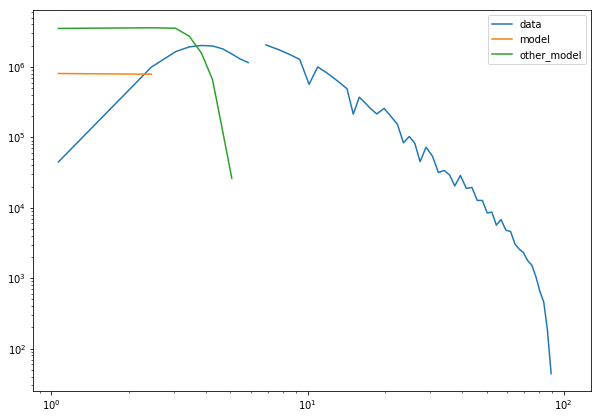

In [113]:
plt.figure(figsize=(10,7))
plt.loglog(bin_mid, data['COUNTS'], label="data")
plt.loglog(bin_mid, m_rmf_c*1e7, label="model")
plt.loglog(bin_mid, m_rmf, label="other_model")
plt.legend()

In [89]:
print(np.min(m_rmf_c*1e6))
print(np.max(m_rmf_c*1e6))

0.0
182184.198231
